#### 本文参考[这里](https://mp.weixin.qq.com/s/BYZI9FfA_jy3M3smijtvkA)

### 时间序列的组成

1. 等级 如果系列是直线，则为该系列的基线值。
2. 趋势 系列随时间的可选且通常线性增加或减少的行为。
3. 季节性 随着时间的推移，可选的重复模式或行为循环。
4. 噪音 模型无法解释的观测值中的可选变异性。

所有的时间序列都有一个等级，即序列是线性的还是非线性的等。因为受到外界不同因素的影响因此多多少少都会有噪音（抑或是这些噪音是未被考虑进去的因子）。

In [40]:
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import seaborn as sns

sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

warnings.filterwarnings("ignore")
%matplotlib inline

In [44]:
raw_data = pd.read_csv("./etf.csv", header=None, parse_dates=[0])
raw_data.head()
raw_data.columns=["date","price","_"]
raw_data.set_index("date",inplace=True)
raw_data.sort_index(ascending=True, inplace=True)
data = raw_data[["price"]].copy()
num = int(data.shape[0] * 0.8)
training_data = data.iloc[:num,:].copy()
testing_data = data.iloc[num:,:].copy()



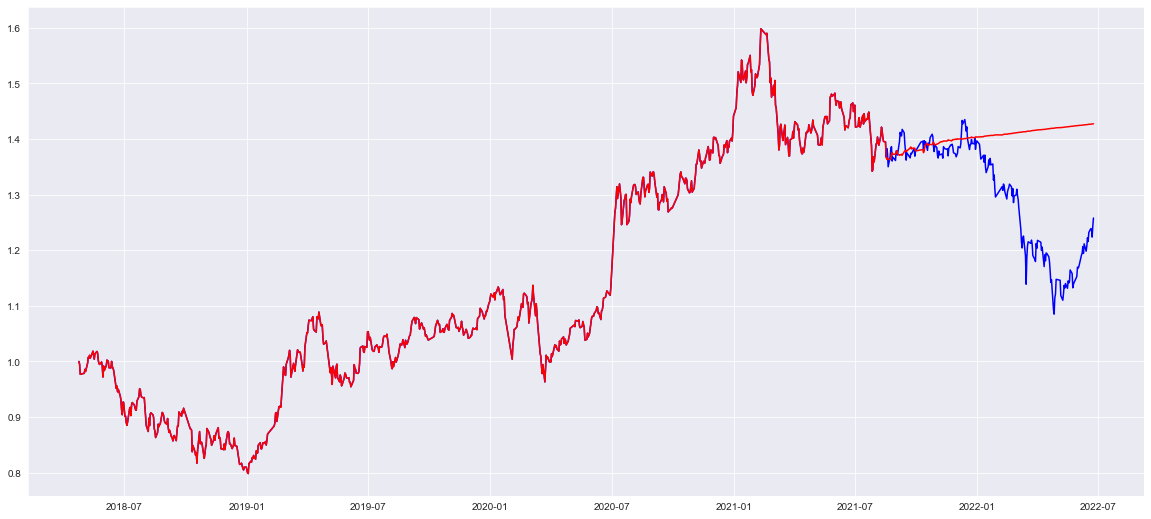

In [79]:
# 1. auto regression
# 自回归 (AR) 方法将序列中的下一步建模为先前时间步长观测值的线性函数。
from statsmodels.tsa.ar_model import AutoReg

# lags: 表示当前时刻的时序信号会受到多少过去时刻的时序信号的影响
model = AutoReg(training_data.price, lags=30, old_names=False)
model_fit = model.fit()
# yhat = model_fit.predict(len(training_data), len(training_data)) # 从哪个数据点开始， 向后预测几个数据点
# model_fit.params # 偏差， 一个时间片之前数据的影响， 3个时间片之前数据的影响，7个时间片之前数据的影响
#  auto regression only predict one point ??
ploting_data = training_data.copy()
model = AutoReg(ploting_data.price, lags=60, old_names=False)
model_fit = model.fit()
for i in range(len(testing_data)):
    yhat = model_fit.predict(len(ploting_data), len(ploting_data)) # the predicted point
    d = pd.DataFrame([yhat.values],columns=["price"] ,index=[testing_data.index[i]])
    ploting_data = ploting_data.append(d)

# show the data 
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(data.index, data.values, 'b')
ax.plot(ploting_data.index, ploting_data.price, 'r')
plt.show()

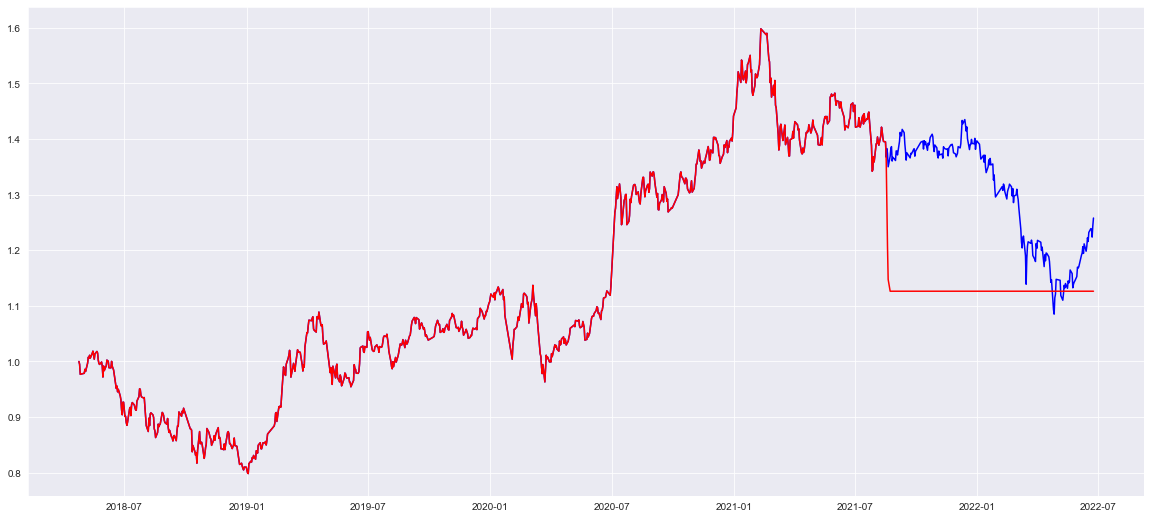

In [77]:
# 2. 移动平均线
# 移动平均（MA）方法将序列中的下一步建模为来自先前时间步骤的平均过程的残余误差的线性函数
ma_training_data = training_data.copy()
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(ma_training_data.price, order=(0, 0, 5))
model_fit = model.fit()
for i in range(len(testing_data)): # need training every time? 
    # make prediction
    yhat = model_fit.predict(len(ma_training_data), len(ma_training_data))
    d = pd.DataFrame([yhat.values],columns=["price"] ,index=[testing_data.index[i]])
    ma_training_data = ma_training_data.append(d)

# show the data 
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(data.index, data.values, 'b')
ax.plot(ma_training_data.index, ma_training_data.price, 'r')
plt.show() # it's ugly cause it predict the data base on the mean value of history


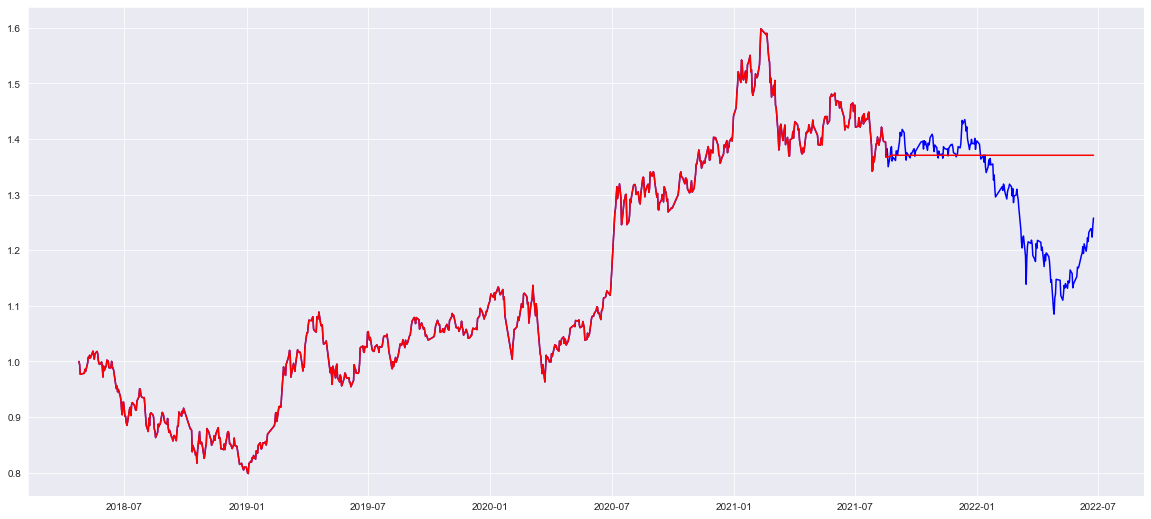

In [112]:
# 3. 自回归移动平均线 ARMA
# 自回归移动平均 (ARMA) 方法将序列中的下一步建模为之前时间步骤的观测值和残差的线性函数。
# ARMA 模型对时间序列的要求是平稳型的
# 某个数据不是能套所有的模型的， 要先进行判断
# AR模型：自相关系数拖尾，偏自相关系数截尾
# MA模型：自相关系数截尾，偏自相关函数拖尾；
# ARMA模型：自相关函数和偏自相关函数均拖尾。

""" 判断方式
# q -> acf; p -> pacf; 选择在置信区间内的值， 看原始值还是看差分？ 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

arma_diff = arma_trining_data.diff().dropna() # 一阶差分

fig, axs = plt.subplots(1,2, figsize=(12, 5))
plot_acf(arma_trining_data.price, lags=20, ax=axs[1])
plot_pacf(arma_trining_data.price, lags=20, ax=axs[0])
plt.show()

"""

arma_trining_data = training_data.copy()
from statsmodels.tsa.arima.model import ARIMA


# # fit model
# make prediction
model = ARIMA(arma_trining_data.price, order=(2,1,1)) # p, d, q
model_fit = model.fit()
for i in range(len(testing_data)):
    yhat = model_fit.predict(len(arma_trining_data), len(arma_trining_data))
    d = pd.DataFrame([yhat.values],columns=["price"] ,index=[testing_data.index[i]])
    arma_trining_data = arma_trining_data.append(d)

# show the data 
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(data.index, data.values, 'b')
ax.plot(arma_trining_data.index, arma_trining_data.price, 'r')
plt.show() # it's ugly cause it predict the data base on the mean value of history data. 



In [115]:
# ADF 单位根检验
from statsmodels.tsa.stattools import adfuller

adfuller(ma_training_data.price,autolag='BIC') # AIC：赤池信息准则，默认；BIC：贝叶斯信息准则
# 即T值，表示T统计量, 即p值，
# 表示T统计量对应的概率值, 
# Lags Used，即表示延迟, 
# Number of Observations Used，即表示测试的次数,

(-1.373741925237234,
 0.594797841356135,
 1,
 1014,
 {'1%': -3.4368154156758943,
  '5%': -2.864394550773568,
  '10%': -2.5682898917327046},
 -5701.951620358455)

In [117]:
adfuller??

Signature:
adfuller(
    x,
    maxlag=None,
    regression='c',
    autolag='AIC',
    store=False,
    regresults=False,
)
Source:   
def adfuller(
    x,
    maxlag=None,
    regression="c",
    autolag="AIC",
    store=False,
    regresults=False,
):
    """
    Augmented Dickey-Fuller unit root test.

    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.

    Parameters
    ----------
    x : array_like, 1d
        The data series to test.
    maxlag : int
        Maximum lag which is included in test, default 12*(nobs/100)^{1/4}.
    regression : {"c","ct","ctt","nc"}
        Constant and trend order to include in regression.

        * "c" : constant only (default).
        * "ct" : constant and trend.
        * "ctt" : constant, and linear and quadratic trend.
        * "nc" : no constant, no trend.

    autolag : {"AIC", "BIC", "t-stat", None}
        Method to use when automatically determin